**Import the necessary Libraries**

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from scipy.stats import chi2
from sklearn.metrics import classification_report

**Data Preprocessing**

In [31]:
# Load the Pima Indians Diabetes dataset
data = pd.read_csv('diabetes.csv')

# Check for null values and basic info
print(data.info())
print(data.describe())

# Normalize the data (excluding the 'Outcome' column)
features = data.drop(columns=['Outcome'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std    

**Z-score Anomaly Detection**

In [32]:
def z_score_method(data_scaled):
    mean = np.mean(data_scaled, axis=0)
    std_dev = np.std(data_scaled, axis=0)
    z_scores = (data_scaled - mean) / std_dev
    return np.abs(z_scores) > 3  # Using a threshold of 3

data['Z-Score Outlier'] = z_score_method(features_scaled).any(axis=1)

**Mahalanobis Distance Calculation**

In [33]:
def mahalanobis_distance(data):
    mean = np.mean(data, axis=0)
    cov_matrix = np.cov(data, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    distances = []
    for point in data:
        delta = point - mean
        distance = np.sqrt(np.dot(np.dot(delta, inv_cov_matrix), delta.T))
        distances.append(distance)
    return np.array(distances)

mdist = mahalanobis_distance(features_scaled)
threshold_md = np.percentile(mdist, 95)  # 95th percentile as a threshold
data['Mahalanobis Outlier'] = mdist > threshold_md

**Local Outlier Factor (LOF)**

In [34]:
lof = LocalOutlierFactor(n_neighbors=20)
data['LOF Outlier'] = lof.fit_predict(features_scaled)
data['LOF Outlier'] = (data['LOF Outlier'] == -1).astype(int)

**Isolation Forest**

In [35]:
iso_forest = IsolationForest(contamination=0.1, random_state=42)
data['Isolation Forest Outlier'] = iso_forest.fit_predict(features_scaled)
data['Isolation Forest Outlier'] = (data['Isolation Forest Outlier'] == -1).astype(int)

**One-Class SVM**

In [36]:
oc_svm = OneClassSVM(gamma='auto', nu=0.1)
oc_svm.fit(features_scaled)
data['One-Class SVM Outlier'] = oc_svm.predict(features_scaled)
data['One-Class SVM Outlier'] = (data['One-Class SVM Outlier'] == -1).astype(int)

**number of anomalies detected**

In [37]:
print("Anomalies detected by each method:")
print(f"Z-Score Outliers: {data['Z-Score Outlier'].sum()}")
print(f"Mahalanobis Outliers: {data['Mahalanobis Outlier'].sum()}")
print(f"LOF Outliers: {data['LOF Outlier'].sum()}")
print(f"Isolation Forest Outliers: {data['Isolation Forest Outlier'].sum()}")
print(f"One-Class SVM Outliers: {data['One-Class SVM Outlier'].sum()}")

Anomalies detected by each method:
Z-Score Outliers: 80
Mahalanobis Outliers: 39
LOF Outliers: 29
Isolation Forest Outliers: 77
One-Class SVM Outliers: 72


**Visualization**

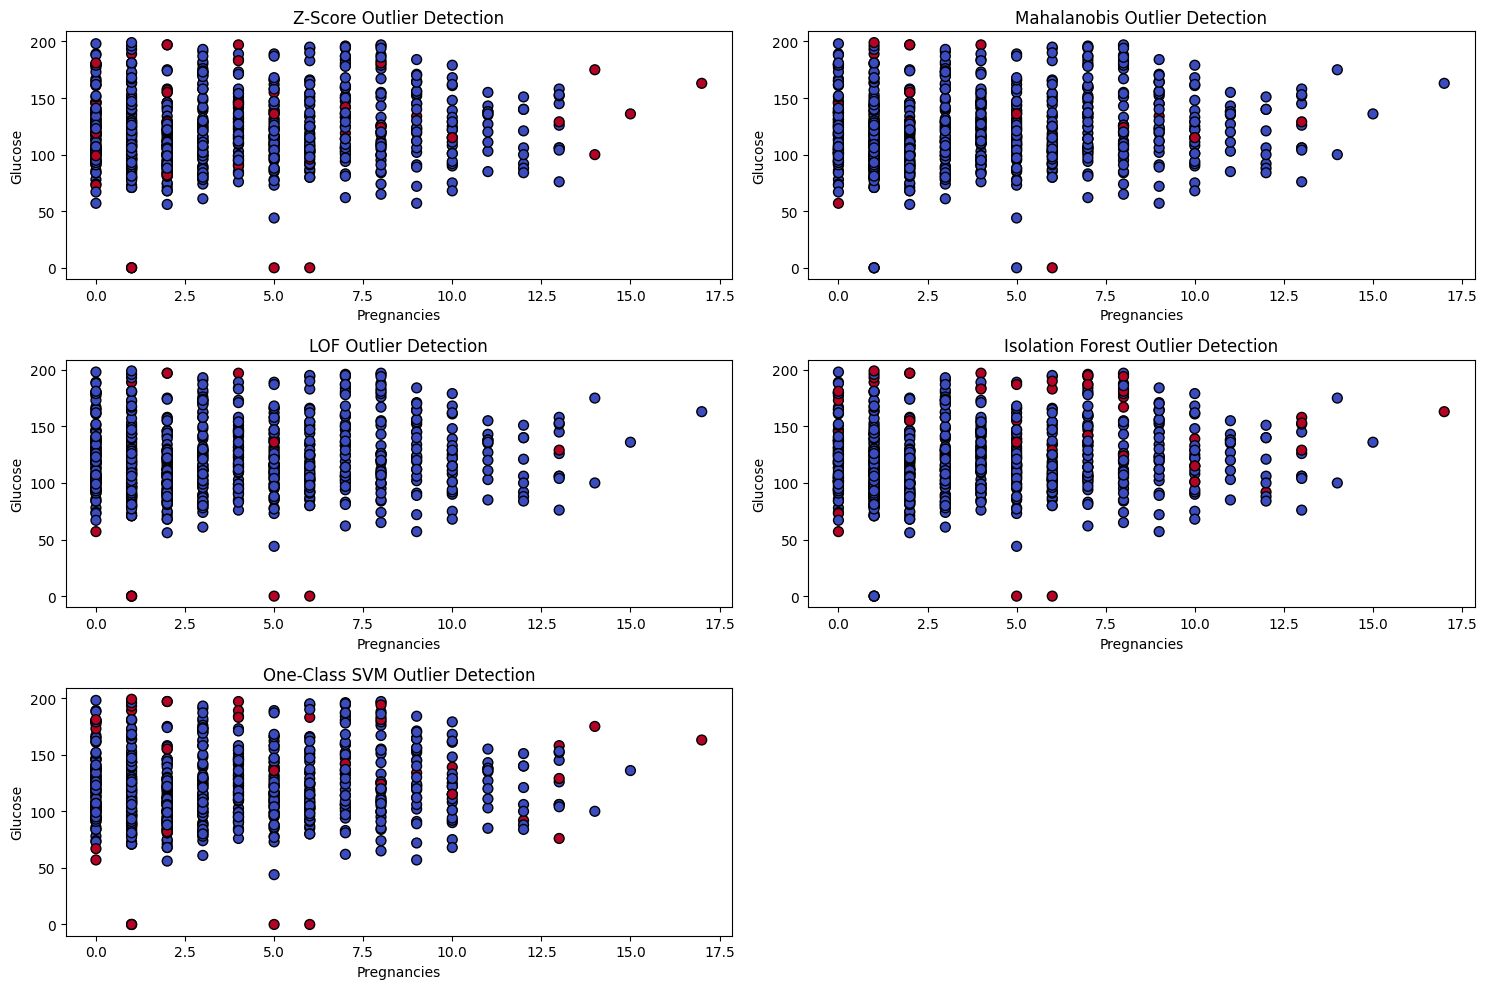

In [38]:
plt.figure(figsize=(15, 10))

# Plot Z-Score Outliers
plt.subplot(3, 2, 1)
plt.scatter(data['Pregnancies'], data['Glucose'], c=data['Z-Score Outlier'], cmap='coolwarm', marker='o', edgecolor='k', s=50)
plt.title('Z-Score Outlier Detection')
plt.xlabel('Pregnancies')
plt.ylabel('Glucose')

# Plot Mahalanobis Outliers
plt.subplot(3, 2, 2)
plt.scatter(data['Pregnancies'], data['Glucose'], c=data['Mahalanobis Outlier'], cmap='coolwarm', marker='o', edgecolor='k', s=50)
plt.title('Mahalanobis Outlier Detection')
plt.xlabel('Pregnancies')
plt.ylabel('Glucose')

# Plot LOF Outliers
plt.subplot(3, 2, 3)
plt.scatter(data['Pregnancies'], data['Glucose'], c=data['LOF Outlier'], cmap='coolwarm', marker='o', edgecolor='k', s=50)
plt.title('LOF Outlier Detection')
plt.xlabel('Pregnancies')
plt.ylabel('Glucose')

# Plot Isolation Forest Outliers
plt.subplot(3, 2, 4)
plt.scatter(data['Pregnancies'], data['Glucose'], c=data['Isolation Forest Outlier'], cmap='coolwarm', marker='o', edgecolor='k', s=50)
plt.title('Isolation Forest Outlier Detection')
plt.xlabel('Pregnancies')
plt.ylabel('Glucose')

# Plot One-Class SVM Outliers
plt.subplot(3, 2, 5)
plt.scatter(data['Pregnancies'], data['Glucose'], c=data['One-Class SVM Outlier'], cmap='coolwarm', marker='o', edgecolor='k', s=50)
plt.title('One-Class SVM Outlier Detection')
plt.xlabel('Pregnancies')
plt.ylabel('Glucose')

plt.tight_layout()
plt.show()


**Evaluating the result**

In [39]:
true_labels = data['Outcome'].values

# Compare results using classification report
print("\nClassification Reports:")
methods = ['Z-Score Outlier', 'Mahalanobis Outlier', 'LOF Outlier', 'Isolation Forest Outlier', 'One-Class SVM Outlier']
for method in methods:
    print(f"\nResults for {method}:")
    print(classification_report(true_labels, data[method]))


Classification Reports:

Results for Z-Score Outlier:
              precision    recall  f1-score   support

           0       0.67      0.92      0.78       500
           1       0.51      0.15      0.24       268

    accuracy                           0.65       768
   macro avg       0.59      0.54      0.51       768
weighted avg       0.62      0.65      0.59       768


Results for Mahalanobis Outlier:
              precision    recall  f1-score   support

           0       0.66      0.96      0.78       500
           1       0.51      0.07      0.13       268

    accuracy                           0.65       768
   macro avg       0.59      0.52      0.46       768
weighted avg       0.61      0.65      0.56       768


Results for LOF Outlier:
              precision    recall  f1-score   support

           0       0.65      0.97      0.78       500
           1       0.41      0.04      0.08       268

    accuracy                           0.64       768
   macro avg 